# Autoencoders

O trabalho embaixo é baseado no paper [Autoencoder-based Network Anomaly Detection.](https://ieeexplore.ieee.org/document/8363930)

Autoencoders são um tipo de rede neural usados para codificar eficientemente um conjunto de dados, de forma não-supervisionada. Geralmente tal codificação reduz a dimensionalidade do dataset.

- Há duas funções associadas: encoding e decoding.
    - Decoding busca reverter a operação, retornando os dados ao espaço original.
- O autoencoder mantém relações não-lineares entre dados, o que não ocorre com métodos de redução de dimensionalidade como PCA

Pode-se detectar anomalias usando PCA ou Autoencoders. O processo envolve projetar os dados em um espaço de menor dimensão e, em seguida, reconstruí-los. Espera-se que os dados normais sigam o padrão aprendido durante o treinamento, resultando em um erro de reconstrução menor. As anomalias, por sua vez, apresentam um erro de reconstrução maior que um limiar ε.
- O autoencoder convolucional usa camadas convolucionais para reduzir o tempo de processamento

Framework do sistema de anomalias via autoencoder:

1. Normalização dos dados
2. Geração de dados 2D (apenas para convolucional) - usou Triangle Area Maps
3. Treinamento do autoencoder - minimizar o erro de reconstrução médio
4. Teste de autoencoder - usa o erro de reconstrução como a “pontuação de anomalia”

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

## Treinamento em Não-Ataques
Primeiramente, buscaremos resultado no dataframe que indiscrimina ataques. Vamos treinar o Autoencoder com todas as instâncias de não-ataque, e tentar predizer os ataques. A expectativa é de um erro de reconstrução alto.

In [3]:
singleclass_df = pd.read_csv("files/5G_attack_detection_ds.csv")
df = singleclass_df.dropna()

# Get non-anomalous labels and features
non_anomalous_data = df[df.iloc[:, -1] == 1]
non_anomalous_labels = non_anomalous_data.iloc[:, -1]
non_anomalous_features = non_anomalous_data.iloc[:, :-1]

# Get anomalous labels and features
anomalous_data = df[df.iloc[:, -1] == -1]
anomalous_labels = anomalous_data.iloc[:, -1]
anomalous_features = anomalous_data.iloc[:, :-1]

# Scale data
scaler = StandardScaler()
non_anomalous_features_scaled = scaler.fit_transform(non_anomalous_features)
anomalous_features_scaled = scaler.transform(anomalous_features)

# Use all non-anomalous data for training
X_train = non_anomalous_features_scaled
y_train = non_anomalous_labels

# Use all anomalous data for testing
X_test = anomalous_features_scaled
y_test = anomalous_labels

Para a arquitetura, utilizaremos a função sigmóide, como no paper.

In [5]:
input_dimension = X_train.shape[1]
input_layer = Input(shape=(input_dimension,))

# Encoder
encoding_layer_1 = Dense(64, activation='sigmoid')(input_layer)
encoding_layer_2 = Dense(32, activation='sigmoid')(encoding_layer_1)
encoding_layer_3 = Dense(16, activation='sigmoid')(encoding_layer_2)
encoding_layer_4 = Dense(8, activation='sigmoid')(encoding_layer_3)

# Decoder
decoding_layer_1 = Dense(8, activation='sigmoid')(encoding_layer_4)
decoding_layer_2 = Dense(16, activation='sigmoid')(decoding_layer_1)
decoding_layer_3 = Dense(32, activation='sigmoid')(decoding_layer_2)
decoding_layer_4 = Dense(64, activation='sigmoid')(decoding_layer_3)
output_layer = Dense(input_dimension, activation='sigmoid')(decoding_layer_4)

# Create the autoencoder model
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

initial_weights = autoencoder.get_weights()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1024)           │        66,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,776 (538.19 KB)

 Trainable params: 137,776 (538.19 KB)

 Non-trainable params: 0 (0.00 B)

Treinando o modelo e calculando o erro de reconstrução (a partir do MSE) para ataques:

In [19]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(X_train, X_train, epochs=200, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

# Reconstruction error on testing
reconstructions = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=1)

Epoch 1/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0936 - val_loss: 0.9993
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0025 - val_loss: 0.9977
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0019 - val_loss: 0.9959
Epoch 4/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0019 - val_loss: 0.9675
Epoch 5/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9528 - val_loss: 0.8981
Epoch 6/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8908 - val_loss: 0.8838
Epoch 7/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8891 - val_loss: 0.8810
Epoch 8/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8875 - val_loss: 0.8803
Epoch 9/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8844 - val_loss: 0.8800
Epoch 10/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8866 - val_loss: 0.8798
Epoch 11/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8820 - val_loss: 0.8797
Epoch 12/200
152/152 ━━━━━━━━━━━━━━━━━━━━

Plotando agora a distribuição dos erros de reconstrução:

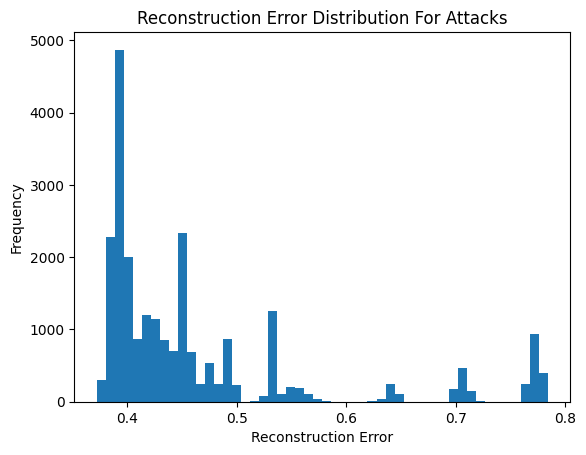

In [20]:
# Define a threshold for anomaly detection
#threshold = np.percentile(reconstruction_errors, 70)

plt.hist(reconstruction_errors, bins=50)
#plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution For Attacks')
plt.show()

Agora, separaremos 20% das não-anomalias ao conjunto de teste, para verificar se há diferença de reconstrução entre os dois.

In [24]:
# Reset weights
autoencoder.set_weights(initial_weights)

# Getting 20% of non-anomalies into training set
num_instances_to_move = int(0.2 * X_train.shape[0])
random_indices = np.random.choice(X_train.shape[0], num_instances_to_move, replace=False)

## Select 20% of the instances and their corresponding labels
X_train_subset = X_train[random_indices]
y_train_subset = y_train.iloc[random_indices]

## Add the selected instances to the test set
X2_test = np.concatenate([X_test, X_train_subset], axis=0)
y2_test = np.concatenate([y_test, y_train_subset], axis=0)

## Remove the selected instances from the training set
X2_train = np.delete(X_train, random_indices, axis=0)
y2_train = y_train.drop(y_train.index[random_indices])

In [25]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(X2_train, X2_train, epochs=200, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

# Reconstruction error on testing
reconstructions = autoencoder.predict(X2_test)
reconstruction_errors = np.mean(np.square(X2_test - reconstructions), axis=1)

Epoch 1/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1094 - val_loss: 1.0059
Epoch 2/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0012 - val_loss: 1.0040
Epoch 3/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9965 - val_loss: 1.0034
Epoch 4/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0021 - val_loss: 1.0027
Epoch 5/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9976 - val_loss: 1.0006
Epoch 6/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9965 - val_loss: 0.9741
Epoch 7/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9565 - val_loss: 0.9061
Epoch 8/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9030 - val_loss: 0.8926
Epoch 9/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8884 - val_loss: 0.8874
Epoch 10/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8766 - val_loss: 0.8854
Epoch 11/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8894 - val_loss: 0.8849
Epoch 12/200
121/121 ━━━━━━━━━━━━━━━━━━━━

Plotando o histograma:

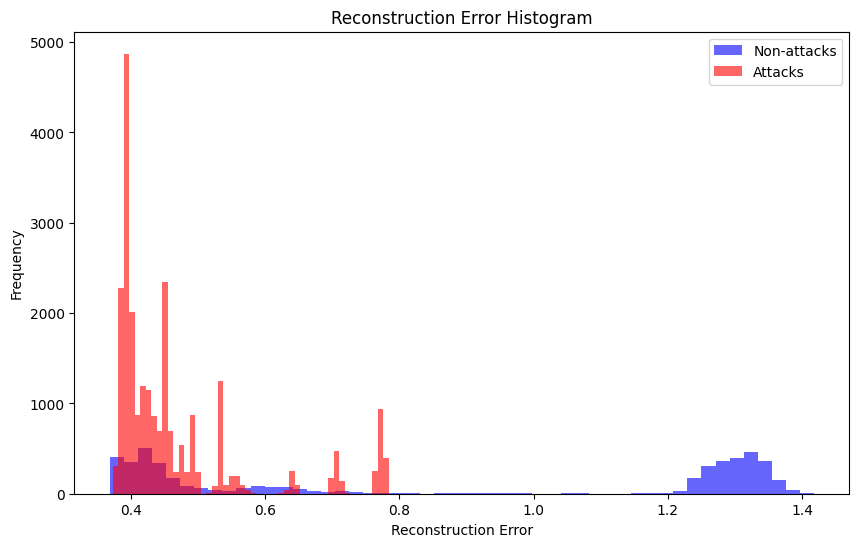

In [26]:
non_attack_errors = reconstruction_errors[y_test == 1]
attack_errors = reconstruction_errors[y_test == -1]

# Plot the histogram
plt.figure(figsize=(10, 6))

plt.hist(non_attack_errors, bins=50, alpha=0.6, color='blue', label='Non-attacks')
plt.hist(attack_errors, bins=50, alpha=0.6, color='red', label='Attacks')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Treinamento em ataques

Como o erro de reconstrução está baixo, vamos fazer o contrário: treinar o autoencoder com os ataques e reconstruir os não-ataques de teste.

In [7]:
# Reset weights
autoencoder.set_weights(initial_weights)

# Swap training and testing datasets
X3_test, X3_train = X_train, X_test
y3_test, y3_train = y_train, y_train

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(X3_train, X3_train, epochs=200, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

# Reconstruction error on testing
reconstructions = autoencoder.predict(X3_test)
reconstruction_errors = np.mean(np.square(X3_test - reconstructions), axis=1)

Epoch 1/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5790 - val_loss: 0.4574
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4588 - val_loss: 0.4573
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4600 - val_loss: 0.4572
Epoch 4/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4586 - val_loss: 0.4571
Epoch 5/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4602 - val_loss: 0.4570
Epoch 6/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4613 - val_loss: 0.4570
Epoch 7/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4602 - val_loss: 0.4570
Epoch 8/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4590 - val_loss: 0.4570
Epoch 9/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4601 - val_loss: 0.4569
Epoch 10/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4599 - val_loss: 0.4569
Epoch 11/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4599 - val_loss: 0.4569
Epoch 12/200
152/152 ━━━━━━━━━━━━━━━━━━━━

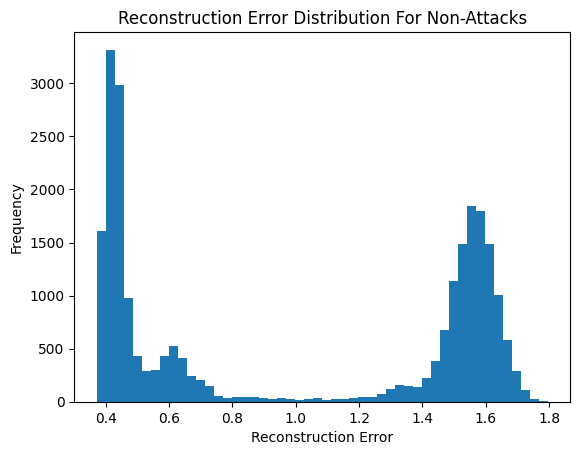

In [8]:
# Define a threshold for anomaly detection
#threshold = np.percentile(reconstruction_errors, 70)

plt.hist(reconstruction_errors, bins=50)
#plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution For Non-Attacks')
plt.show()

Vamos também separar 20% dos ataques para ver como os erros de reconstrução ocorrem

In [11]:
# Reset weights
autoencoder.set_weights(initial_weights)

# Getting 20% of non-anomalies into training set
num_instances_to_move = int(0.2 * X3_train.shape[0])
random_indices = np.random.choice(X3_train.shape[0], num_instances_to_move, replace=False)

## Select 20% of the instances and their corresponding labels
X4_train_subset = X3_train[random_indices]
y4_train_subset = y3_train.iloc[random_indices]

## Add the selected instances to the test set
X4_test = np.concatenate([X3_test, X4_train_subset], axis=0)
y4_test = np.concatenate([y3_test, y4_train_subset], axis=0)

## Remove the selected instances from the training set
X4_train = np.delete(X3_train, random_indices, axis=0)
y4_train = y3_train.drop(y3_train.index[random_indices])

In [12]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(X4_train, X4_train, epochs=200, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

# Reconstruction error on testing
reconstructions = autoencoder.predict(X4_test)
reconstruction_errors = np.mean(np.square(X4_test - reconstructions), axis=1)

Epoch 1/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5967 - val_loss: 0.4578
Epoch 2/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4586 - val_loss: 0.4577
Epoch 3/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4589 - val_loss: 0.4576
Epoch 4/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4588 - val_loss: 0.4575
Epoch 5/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4599 - val_loss: 0.4575
Epoch 6/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4604 - val_loss: 0.4574
Epoch 7/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4591 - val_loss: 0.4574
Epoch 8/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4593 - val_loss: 0.4574
Epoch 9/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4605 - val_loss: 0.4574
Epoch 10/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4586 - val_loss: 0.4573
Epoch 11/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4601 - val_loss: 0.4573
Epoch 12/200
121/121 ━━━━━━━━━━━━━━━━━━━━

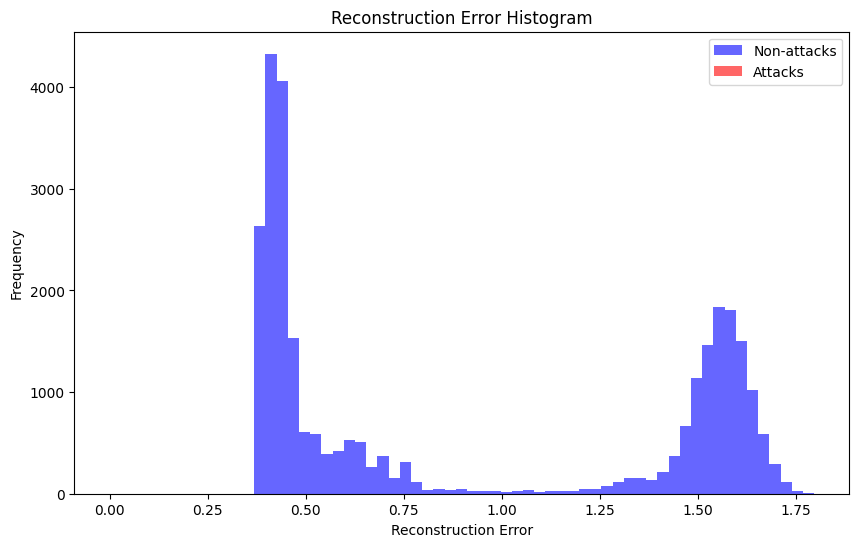

In [14]:
non_attack_errors = reconstruction_errors[y4_test == 1]
attack_errors = reconstruction_errors[y4_test == -1]

# Plot the histogram
plt.figure(figsize=(10, 6))

plt.hist(non_attack_errors, bins=50, alpha=0.6, color='blue', label='Non-attacks')
plt.hist(attack_errors, bins=50, alpha=0.6, color='red', label='Attacks')

plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

FUNC PROX

In [27]:
def compare_results(anomalies_found, anomaly_label):
    anomaly_labels = anomaly_label == -1

    # Compare the arrays
    correctly_identified = (anomalies_found == anomaly_labels)

    # Calculate the number of correctly identified anomalies
    correct_count = correctly_identified.sum()

    # Calculate the total number of anomalies and normal instances
    total_anomalies = anomaly_labels.sum()
    total_normal = (~anomaly_labels).sum()

    num_anomalies_detected = anomalies_found.sum()
    print(f"Number of anomalies detected: {num_anomalies_detected}")

    # Calculate accuracy, precision, recall, etc.
    accuracy = correct_count / len(anomalies_found)

    true_positives = (anomalies_found & anomaly_labels).sum()
    false_positives = (anomalies_found & ~anomaly_labels).sum()
    true_negatives = (~anomalies_found & ~anomaly_labels).sum()
    false_negatives = (~anomalies_found & anomaly_labels).sum()

    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"True Negatives: {true_negatives}")
    print(f"False Negatives: {false_negatives}")

    if anomalies_found.sum() > 0:
        precision = true_positives / anomalies_found.sum()
    else:
        precision = 0.0  # To handle division by zero

    if total_anomalies > 0:
        recall = true_positives / total_anomalies
    else:
        recall = 0.0  # To handle division by zero

    print()

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

compare_results(anomalies, S_y_test)

NameError: name 'anomalies' is not defined